<a href="https://colab.research.google.com/github/dannyjammooa/LANL/blob/main/Four_qbit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install qiskit;

In [201]:
import numpy as np
import warnings
from tqdm.auto import tqdm
import qiskit as qk
from qiskit.circuit import QuantumCircuit, Parameter
from qiskit import Aer, assemble
from qiskit.visualization import circuit_drawer, plot_histogram, plot_state_qsphere
from qiskit import *
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from numpy import linalg as la
from sympy import *
from sympy import Matrix, Inverse, diag, GramSchmidt
from sympy import Symbol
from sympy.physics.quantum import TensorProduct
from numpy.linalg import inv
pi = np.pi
%matplotlib inline
from qiskit import IBMQ
IBMQ.save_account('5e716052aec669f447b21719efe891c73d8d13c7d00c226b16bac3004940300f49f9c54ab14a0d79d871a0aafbc6992f056be94eddb98ab80ff45d711c30f541')
IBMQ.load_account()

configrc.store_credentials:WARNING:2021-08-02 17:09:44,277: Credentials already present. Set overwrite=True to overwrite.
ibmqfactory.load_account:WARNING:2021-08-02 17:09:44,461: Credentials are already in use. The existing account in the session will be replaced.


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

# Functions

## Measures

In [202]:
#Measurment Functions

#execute the circuit using qasm_simulator as backend
def execute_QC(quantum_circuit,shot):
  simulator = Aer.get_backend('qasm_simulator')
  result = execute(quantum_circuit, backend=simulator, shots=shot).result().get_counts()
  return result

def execute_QC_IBM(quantum_circuit,shot):
  provider = IBMQ.get_provider('ibm-q')
  qcomp = provider.get_backend('ibmq_5_yorktown')
  result = execute(quantum_circuit, backend=qcomp, shots=shot).result().get_counts()
  return result

#X-basis
def X_measurement(qc, qubit, cbit):
    """Measure 'qubit' in the X-basis, and store the result in 'cbit'"""
    qc.h(qubit)
    qc.measure(qubit, cbit)
    return qc

#Y-basis
def Y_measurement(qc, qubit, cbit):
   """Measure 'qubit' in the Y-basis, and store the result in 'cbit'"""
   qc.sdg(qubit)
   qc.h(qubit)
   qc.measure(qubit, cbit)
   return qc

#ZZ-basis
def ZZ_measurement(qc,qubit1,qubit2,cbit1,cbit2):
  qc.measure(qubit1,cbit1)
  qc.measure(qubit2,cbit2)
  return qc

#XX-basis
def XX_measurement(qc,qubit1,qubit2,cbit1,cbit2):
  qc.h(qubit1)
  qc.h(qubit2)
  qc.measure(qubit1,cbit1)
  qc.measure(qubit2,cbit2)
  return qc

#YY-basis
def YY_measurement(qc,qubit1,qubit2,cbit1,cbit2):
  qc.sdg(qubit1)
  qc.sdg(qubit2)
  qc.h(qubit1)
  qc.h(qubit2)
  qc.measure(qubit1,cbit1)
  qc.measure(qubit2,cbit2)
  return qc

#combinding all measurement into one function
def Measure(qc, basis, qubit1,qubit2,cbit1,cbit2):
  if basis == 'Z1':
    qc.measure([qubit1],[cbit1])
  elif basis =='Z2':
    qc.measure([qubit2],[cbit2])
  elif basis == 'Y':
    Y_measurement(qc,qubit1,cbit1)
  elif basis == 'X':
    X_measurement(qc,qubit1,cbit1)
  elif basis == 'ZZ':
    ZZ_measurement(qc, qubit1,qubit2,cbit1,cbit2)
  elif basis == 'YY':
    YY_measurement(qc, qubit1,qubit2,cbit1,cbit2)
  elif basis == 'XX':
    XX_measurement(qc, qubit1,qubit2,cbit1,cbit2)
  return qc

## Gates and running Circuits

In [277]:
#choosing our initial state
def Initial_State(quantum_circuit,IS,nqbits):
  if IS == 'odd': #skips odd numbered qubits
    for idx in range(nqbits):
      if idx%2 == 0: 
        continue
      else:
        quantum_circuit.x(idx)
  elif IS =='even': #skips odd numbered qubits
    for idx in range(nqbits):
      if idx%2 == 0: 
        quantum_circuit.x(idx)
      else:
        continue
  elif IS == 'alldown':
    for idx in range(nqbits):
      quantum_circuit.x(idx)
  elif IS =='allup':
    for idx in range(nqbits):
      quantum_circuit.id(idx)
  elif IS == '01':
    for idx in range(nqbits):
      if idx%2 == 0:
        quantum_circuit.h(idx)
        quantum_circuit.cx(idx,idx+1)
      else:
        quantum_circuit.x(idx)
  elif IS == '11':
    for idx in range(nqbits):
      quantum_circuit.x(idx)
      if idx%2 == 0:
        quantum_circuit.h(idx)
        quantum_circuit.cx(idx,idx+1)
      else:
        continue
  return quantum_circuit

#N(alpha,beta,gamma) gate from the paper
#Half time step
def SWAP1(var,t):
  Thalf = 0/5*t
  a = var[0]
  b = var[1]
  y = var[2]
  theta = pi/2 - 2*y*Thalf
  phi = 2*a*Thalf -pi/2
  lamda = pi/2 -2*b*Thalf
  qc = QuantumCircuit(2, name='Half')
  qc.rz(-pi/2,1)
  qc.cx(1,0)
  qc.rz(theta,0)
  qc.ry(phi,1)
  qc.cx(0,1)
  qc.ry(lamda,1)
  qc.cx(1,0)
  qc.rz(pi/2,0)
  return qc

#N(alpha,beta,gamma) gate from the paper
#Full time step
def SWAP2(var,t):
  a = var[0]
  b = var[1]
  y = var[2]
  theta = pi/2 - 2*y*t  #angle that depend on the zz two-body coefficient
  phi = 2*a*t -pi/2     #angle that depend on the xx two-body coefficient
  lamda = pi/2 -2*b*t   #angle that depend on the yy two-body coefficient
  qc = QuantumCircuit(2, name='Full')
  qc.rz(-pi/2,1)
  qc.cx(1,0)
  qc.rz(theta,0)
  qc.ry(phi,1)
  qc.cx(0,1)
  qc.ry(lamda,1)
  qc.cx(1,0)
  qc.rz(pi/2,0)
  return qc

#The full unitary time evolution 
def Unitary(quantum_circuit,var,nqbits,h,t):
  Thalf = 0.5*t
  psi = h*Thalf  #angle that depends on the z one-body coefficient
  #one-body term
  for idx in range(nqbits):
    quantum_circuit.rz(psi,idx) 
  quantum_circuit.barrier()
  #two-body term / odd qubits swaped/ half time step
  for idx in range(nqbits):
    if idx%2 == 0:
      continue
    else:
      if idx == nqbits-1:
        break
      else:
        quantum_circuit.append(SWAP1(var,t), [idx,idx+1])
  #two-body term / even qubits swaped/ full time step
  for idx in range(nqbits):
    if idx%2 == 1:
      continue
    else:
      if idx == nqbits:
        break
      else:
        quantum_circuit.append(SWAP2(var,t), [idx,idx+1])
  #two-body term / odd qubits swaped/ half time step
  for idx in range(nqbits):
    if idx%2 == 0:
      continue
    else:
      if idx == nqbits-1:
        break
      else:
        quantum_circuit.append(SWAP1(var,t), [idx,idx+1])
  quantum_circuit.barrier()
  #one-body term
  for idx in range(nqbits):
    quantum_circuit.rz(psi,idx) 
  return quantum_circuit

#applies trotter steps
def Trotter(quantum_circuit, numTstep, nqbits, var, h, t):
  for i in range(numTstep):
      Unitary(quantum_circuit, var, nqbits, h, t)
  return quantum_circuit

#creates our quantum Circuit
def Quantum_Circuit(IS,nqbits, var, numTstep,h,t):
     QC = QuantumCircuit(nqbits)
     Initial_State(QC,IS,nqbits)
     QC.barrier()
     Trotter(QC,numTstep,nqbits,var,h,t)
     return QC

#creates/measures/excute our quantum circuit and stores the probabilies of measured circuit
def Results(IS,nqbits,numTstep,basis,var,shots,h,t):
  Energy = []
  for initialstate in IS:
    E = []
    qc = Quantum_Circuit(initialstate,nqbits,var,numTstep,h,t)
    for measure_circuit in basis:
      QQ = QuantumCircuit(nqbits,2)
      QX = qc+Measure(QQ, measure_circuit,0,1,0,1)
      counts = execute_QC(QX,shots)
      probs = {}
      for output in ['00','01', '10', '11']:
        if output in counts:
          probs[output] = counts[output]/shots
        else:
          probs[output] = 0
      E.append(probs['00']-probs['01']-probs['10']+probs['11'])
    Energy.append(E)
  return Energy

#creates/measures/excute our quantum circuit and stores the probabilies of measured circuit
def Results_IBM(IS,nqbits,numTstep,basis,var,shots,h,t):
  Energy = []
  for initialstate in IS:
    E = []
    qc = Quantum_Circuit(initialstate,nqbits,var,numTstep,h,t)
    for measure_circuit in basis:
      QQ = QuantumCircuit(nqbits,2)
      QX = qc+Measure(QQ, measure_circuit,0,1,0,1)
      counts = execute_QC_IBM(QX,shots)
      probs = {}
      for output in ['00','01', '10', '11']:
        if output in counts:
          probs[output] = counts[output]/shots
        else:
          probs[output] = 0
      E.append(probs['00']-probs['01']-probs['10']+probs['11'])
    Energy.append(E)
  return Energy


def Results2(IS,nqbits,numTstep,basis,var,shots,h,t):
  prob00 = []
  prob01 = []
  prob10 = []
  prob11 = []
  qc = Quantum_Circuit(IS,nqbits,var,numTstep,h,t)
  for measure_circuit in basis:
    QQ = QuantumCircuit(nqbits,2)
    QX = qc+Measure(QQ, measure_circuit,0,1,0,1)
    counts = execute_QC(QX,shots)
    probs = {}
    for output in ['00','01', '10', '11']:
      if output in counts:
        probs[output] = counts[output]/shots
      else:
        probs[output] = 0
    prob00.append(probs['00'])
    prob10.append(probs['01'])
    prob01.append(probs['10'])
    prob11.append(probs['11'])
  return prob00, prob01, prob10, prob11

def Results3(IS,nqbits,numTstep,basis,var,shots,h,t):
  Energy = []
  for initialstate in IS:
    E = []
    qc = Quantum_Circuit(initialstate,nqbits,var,numTstep,h,t)
    for measure_circuit in basis:
      for i in range(nqbits):
        if measure_circuit == basis[0]:
          qx = QuantumCircuit(nqbits,2)
          QX = qc + Measure(qx,measure_circuit,i,i+1,0,1)
        else:
          if i == qbit-1:
            break
          else:
            qx = QuantumCircuit(nqbits,2)
            QX = qc + Measure(qx,measure_circuit,i,i+1,0,1)
        counts = execute_QC(QX,shots)
        probs = {}
        for output in ['00','01', '10', '11']:
          if output in counts:
            probs[output] = counts[output]/shots
          else:
            probs[output] = 0
        E.append(probs['00']-probs['01']-probs['10']+probs['11'])
    Energy.append(E)
  return Energy

def Energy(E,A,B):
  return B*(E[0]+E[1]+E[2]+E[3])+ A*(E[4]+E[5]+E[6]+E[7]+E[8]+E[9]+E[10]+E[11]+E[12])

# Two qbit

In [249]:
A =  1
B = 0.3

X = Matrix([[0,1],[1,0]])
Y = Matrix([[0,-1j],[1j,0]])
Z = Matrix([[1,0],[0,-1]])
I = Matrix([[1,0],[0,1]])

XX = TensorProduct(X,X)
YY = TensorProduct(Y,Y)
ZZ = TensorProduct(Z,Z)
Z1 = TensorProduct(I,Z)
Z2 = TensorProduct(Z,I)

H = A*(XX+YY+ZZ) + B*(Z2+Z1)

D = diag(H)
D.eigenvals()
G = D.eigenvects()
L = [Matrix(G[0][2]),Matrix(G[1][2]),Matrix(G[2][2]),Matrix(G[3][2])]
out = GramSchmidt(L,True)
print('E=',G[3][0],'vec=',out[0])
print('E=',G[2][0],'vec=',out[1])
print('E=',G[0][0],'vec=',out[2])
print('E=',G[1][0],'vec=',out[3])

E= 0.400000000000000 vec= Matrix([[1.00000000000000], [0], [0], [0]])
E= 1.00000000000000 vec= Matrix([[0], [0.707106781186548], [-0.707106781186548], [0]])
E= 1.60000000000000 vec= Matrix([[0], [-0.707106781186548], [-0.707106781186548], [0]])
E= -3.00000000000000 vec= Matrix([[0], [0], [0], [1.00000000000000]])


## Simulator

In [250]:
Energy = []
Shots= 10000 #number of shots
qbit = 2 #size of circuit
trotter = 1 #number of trotter steps
t= 0.1 #time
basis = ['Z1','Z2','ZZ','XX','YY'] #measures the circuit given said basis
A = 1 #the two-body constant A 
B = 0.3 #the one-body constant B 
Var = np.array([A,A,A]) #since alpha=beta=gamma=A in this problem
PSI = ['allup','01','alldown','11']
E = Results(PSI,qbit,trotter,basis,Var,Shots,B,t)
for IS in PSI:
  if IS == 'allup':
    Energy.append(-B*(E[0][0]+E[0][1])+A*(E[0][2]+E[0][3]+E[0][4]))
  elif IS == '01':
    Energy.append(0*(E[1][0]+E[1][1])+A*(E[1][2]+E[1][3]+E[1][4])) 
  elif IS == 'alldown':
    Energy.append(-B*(E[2][0]+E[2][1])+A*(E[2][2]+E[2][3]+E[2][4])) 
  elif IS == '11':
    Energy.append(0*(E[3][0]+E[3][1])+A*(E[3][2]+E[3][3]+E[3][4])) 
print('PSI_1,-1:','Analytical solution E=',A-2*B,'Quantum Simulation E =',Energy[0])
print('PSI_1,0:','Analytical solution E=',A,'Quantum Simulation E =',Energy[1])
print('PSI_1,1:','Analytical solution E=',A+2*B,'Quantum Simulation E =',Energy[2])
print('PSI_0,0:','Analytical solution E=',-3*A,'Quantum Simulation E =',Energy[3])

PSI_1,-1: Analytical solution E= 0.4 Quantum Simulation E = 0.3974000000000001
PSI_1,0: Analytical solution E= 1 Quantum Simulation E = 1.0
PSI_1,1: Analytical solution E= 1.6 Quantum Simulation E = 1.5879999999999999
PSI_0,0: Analytical solution E= -3 Quantum Simulation E = -3.0


## Quantum Computer

In [273]:
Energy = []
Shots= 8192 #number of shots
qbit = 2 #size of circuit
trotter = 1 #number of trotter steps
t= 0.1 #time
basis = ['Z1','Z2','ZZ','XX','YY'] #measures the circuit given said basis
A = 1 #the two-body constant A 
B = 0.3 #the one-body constant B 
Var = np.array([A,A,A]) #since alpha=beta=gamma=A in this problem
PSI = ['allup','01','alldown','11']
E = Results_IBM(PSI,qbit,trotter,basis,Var,Shots,B,t)
for IS in PSI:
  if IS == 'allup':
    Energy.append(-B*(E[0][0]+E[0][1])+A*(E[0][2]+E[0][3]+E[0][4]))
  elif IS == '01':
    Energy.append(0*(E[1][0]+E[1][1])+A*(E[1][2]+E[1][3]+E[1][4])) 
  elif IS == 'alldown':
    Energy.append(-B*(E[2][0]+E[2][1])+A*(E[2][2]+E[2][3]+E[2][4])) 
  elif IS == '11':
    Energy.append(0*(E[3][0]+E[3][1])+A*(E[3][2]+E[3][3]+E[3][4])) 
print('PSI_1,-1:','Analytical solution E=',A-2*B,'Quantum Simulation E =',Energy[0])
print('PSI_1,0:','Analytical solution E=',A,'Quantum Simulation E =',Energy[1])
print('PSI_1,1:','Analytical solution E=',A+2*B,'Quantum Simulation E =',Energy[2])
print('PSI_0,0:','Analytical solution E=',-3*A,'Quantum Simulation E =',Energy[3])

PSI_1,-1: Analytical solution E= 0.4 Quantum Simulation E = 0.07136230468749999
PSI_1,0: Analytical solution E= 1 Quantum Simulation E = 0.418212890625
PSI_1,1: Analytical solution E= 1.6 Quantum Simulation E = 0.5961181640625
PSI_0,0: Analytical solution E= -3 Quantum Simulation E = -1.25732421875


#4 qbit

In [253]:
#ZZ
Z0Z1 = TensorProduct(I,I,Z,Z)
Z1Z2 = TensorProduct(I,Z,Z,I)
Z2Z3 = TensorProduct(Z,Z,I,I)

#XX
X0X1 = TensorProduct(I,I,X,X)
X1X2 = TensorProduct(I,X,X,I)
X2X3 = TensorProduct(X,X,I,I)

#YY
Y0Y1 = TensorProduct(I,I,Y,Y)
Y1Y2 = TensorProduct(I,Y,Y,I)
Y2Y3 = TensorProduct(Y,Y,I,I)

#Z
Z0 = TensorProduct(I,I,I,Z)
Z1 = TensorProduct(I,I,Z,I)
Z2 = TensorProduct(I,Z,I,I)
Z3 = TensorProduct(Z,I,I,I)

H = A*(X0X1 + X1X2 + X2X3 + Y0Y1 + Y1Y2 +Y2Y3 + Z0Z1 + Z1Z2 + Z2Z3) + B*(Z0+Z1+Z2+Z3)
D = diag(H)
G= D.eigenvects()
D.eigenvals()
LL = [Matrix(G[0][2]),Matrix(G[1][2]),Matrix(G[2][2]),Matrix(G[3][2]),Matrix(G[4][2]),Matrix(G[5][2]),Matrix(G[6][2]),Matrix(G[7][2]),Matrix(G[8][2]),Matrix(G[9][2]),Matrix(G[10][2]),Matrix(G[11][2]),Matrix(G[12][2]),Matrix(G[13][2]),Matrix(G[14][2]),Matrix(G[15][2])]
out = GramSchmidt(LL,True)
print('E=',G[0][0],'vec=',out[0])
print('E=',G[15][0],'vec=',out[15])

E= 4.20000000000000 vec= Matrix([[1.00000000000000], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0]])
E= 1.80000000000000 vec= Matrix([[0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [1.00000000000000]])


## Simulator

In [278]:
Shots= 10000 #number of shots
qbit = 4 #size of circuit
trotter = 1 #number of trotter steps
t= 0.1 #time
basis = ['Z1','ZZ','XX','YY'] #measures the circuit given said basis
A = 1 #the two-body constant A 
B = 0.3 #the one-body constant B 
Var = np.array([A,A,A]) #since alpha=beta=gamma=A in this problem
PSI = ['allup','alldown']#['allup','alldown']#,'alldown']
E = Results3(PSI,qbit,trotter,basis,Var,Shots,B,t)
print('|0000>',Energy(E[0],A,B))
print('|1111>',Energy(E[1],A,B))

|0000> 4.2184
|1111> 1.8517999999999997


## T = trotter*deltat

In [280]:
# t = 0.1
Shots= 10000 #number of shots
qbit = 4 #size of circuit
trotter = np.arange(1,10,1) #number of trotter steps
t = 0.1
basis = ['Z1','ZZ','XX','YY'] #measures the circuit given said basis
A = 1 #the two-body constant A 
B = 0.3 #the one-body constant B 
Var = np.array([A,A,A]) #since alpha=beta=gamma=A in this problem
PSI = ['allup']
ENG1 = []
Dt1 = []
for i in range(len(trotter)):
  delt = t/trotter[i]
  E = Results3(PSI,qbit,trotter[i],basis,Var,Shots,B,delt)
  ENG1.append(Energy(E[0],A,B))
  Dt1.append(delt)
print(ENG1)

[4.1628, 4.207, 4.175800000000001, 4.2056, 4.2428, 4.227199999999999, 4.2136, 4.1768, 4.2132]


Text(0, 0.5, 'Energy')

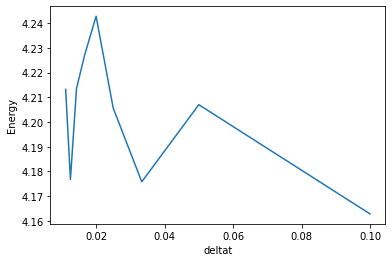

In [281]:
plt.plot(Dt1,ENG1)
plt.xlabel('deltat')
plt.ylabel('Energy')

In [282]:
#t = 0.5
Shots= 10000 #number of shots
qbit = 4 #size of circuit
trotter = np.arange(1,10,1) #number of trotter steps
t = 0.5
basis = ['Z1','ZZ','XX','YY'] #measures the circuit given said basis
A = 1 #the two-body constant A 
B = 0.3 #the one-body constant B 
Var = np.array([A,A,A]) #since alpha=beta=gamma=A in this problem
PSI = ['allup']
Eng2 = []
Dt2 = []
for i in range(len(trotter)):
  delt = t/trotter[i]
  E = Results3(PSI,qbit,trotter[i],basis,Var,Shots,B,delt)
  Eng2.append(Energy(E[0],A,B))
  Dt2.append(delt)
print(Eng2)

[4.207, 4.1788, 4.1542, 4.1903999999999995, 4.2142, 4.234, 4.1852, 4.1636, 4.2444]


Text(0, 0.5, 'Energy')

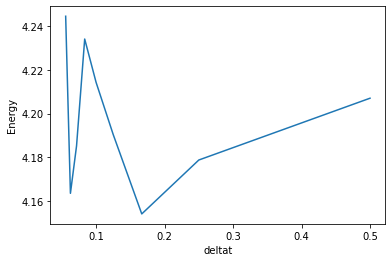

In [283]:
plt.plot(Dt2,Eng2)
plt.xlabel('deltat')
plt.ylabel('Energy')